In [1]:
import pandas as pd
import statistics 
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from matplotlib import interactive
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [2]:
def read_csv(file_name):
    file_path = "D:/realAdExchange/realAdExchange/" + file_name
    return pd.read_csv(file_path, low_memory=False)

In [8]:
df = read_csv("exchange-4_cpc_results.csv")


In [43]:
df.head()
# some function for later

# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance


In [9]:
# Feature engineering
#Clean up datetime attribute
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)


# the day of the week (Monday=0, Sunday=6), if it's a week end day or week day, and the yearly quarter.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
df['YearlyQuarter'] = df['timestamp'].dt.quarter

# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.115

# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

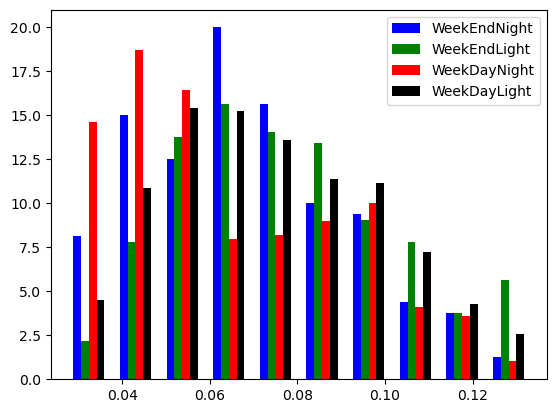

In [13]:
# Plot and check for details
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')
plt.legend()
plt.show()

In [22]:
# A median range of data is between $0.05 - $0.08
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# PCA feature analysis
pca = PCA()
data = pca.fit_transform(data)

print(pca.components_)
print(pca.explained_variance_)
print("Percentage of Variance Explained by Each Component: \n", pca.components_/sum(pca.components_))
# We can see that the PCA Analysis shows that the values are explained better with the top 3 features in data DF

[[ 0.07771206  0.03956005  0.04182328  0.7034076  -0.7041764 ]
 [ 0.09360663  0.69937741  0.70563057 -0.04649066  0.04509051]
 [ 0.98818598 -0.13474746 -0.00412916 -0.06022186  0.04108366]
 [ 0.09212727  0.70081117 -0.7073206  -0.00853487 -0.00099753]
 [ 0.0141304   0.00361461 -0.00410265  0.70665186  0.70739916]]
[1.79866741 1.61985387 0.99565978 0.38155642 0.20730759]
Percentage of Variance Explained by Each Component: 
 [[ 6.13954600e+00  3.02304517e+00  1.31101510e+02  5.43250724e+01
  -7.96585087e+02]
 [ 7.39527661e+00  5.34440604e+01  2.21190771e+03 -3.59053313e+00
   5.10077077e+01]
 [ 7.80704208e+01 -1.02969459e+01 -1.29434988e+01 -4.65101145e+00
   4.64750495e+01]
 [ 7.27840206e+00  5.35536240e+01 -2.21720535e+03 -6.59159326e-01
  -1.12843965e+00]
 [ 1.11635452e+00  2.76216305e-01 -1.28603742e+01  5.45756315e+01
   8.00230769e+02]]


In [31]:
# reduce to 3 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# standardize these 3 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 6)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
#fig, ax = plt.subplots()
#plt.show()
print(kmeans, scores)

[KMeans(n_clusters=1), KMeans(n_clusters=2), KMeans(n_clusters=3), KMeans(n_clusters=4), KMeans(n_clusters=5)] [-3285.9999999999977, -1825.6747256815152, -537.8254421925396, -399.0517890416838, -281.3068990916398]


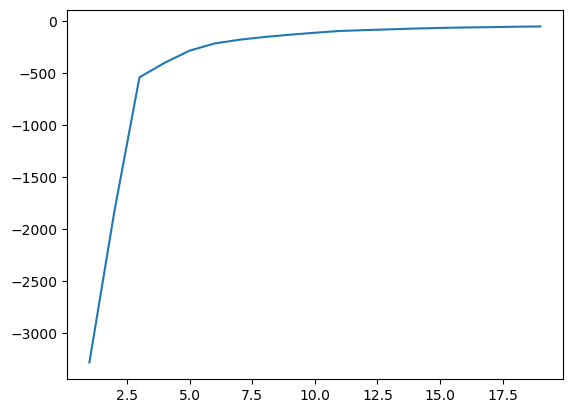

In [32]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [36]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[5].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts().sort_values()

5      1
2      6
1      9
3    481
0    520
4    626
Name: cluster, dtype: int64

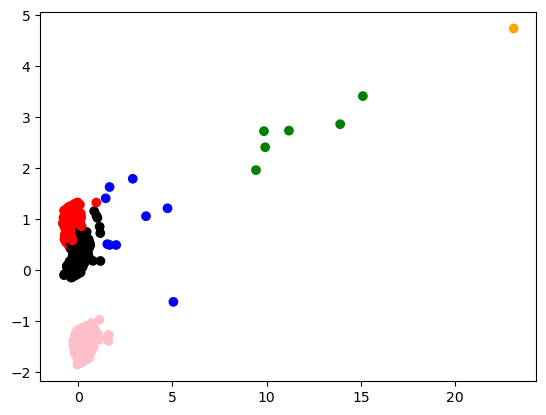

In [37]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [74]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[13])
outliers_fraction = 0.015
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

C:\Users\Cigil Achenkunju\AppData\Local\Temp\ipykernel_19932\252360150.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series()


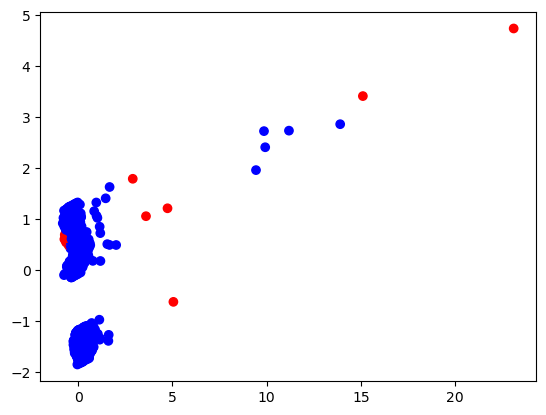

In [75]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

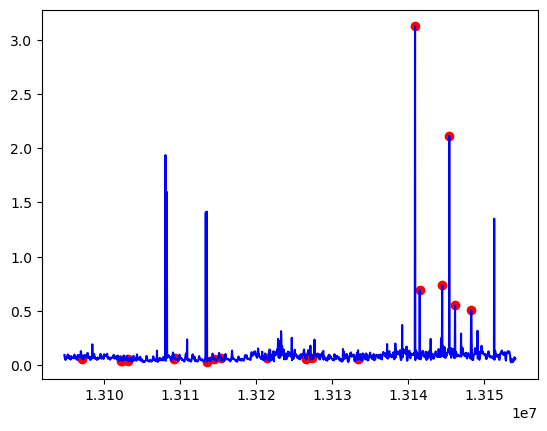

In [76]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

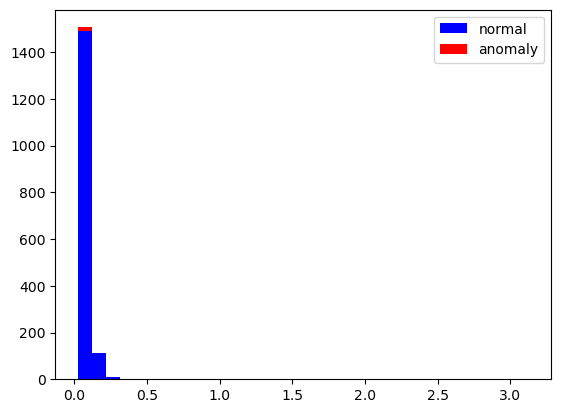

In [77]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()